***
**Tutorial 5 for Chapter 2**

Case study 7: College Attending Plan Modeled by Random Forest
***
<font color = 'darkred'>*Reference:*
<font color = 'darkred'>*Python数据挖掘实战*

<!-- Acknowledgement:  
**i2DM (Tan, Steinbach, Kumar (2018) Introduction to Data Mining , 2nd Ed, Pearson )** Pearson Press   -->
For the tutorial course of AMA546 Statistical Data Mining   
Lecturer: Mr. Qiuyi Huang  
PolyU, HKSAR

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder # Import one-hot encoder
from scipy.sparse import hstack # Import hstack to stack the data
from sklearn.tree import DecisionTreeClassifier # Import the decision tree classifier
from sklearn.tree import plot_tree # Impor the tree plot module to plot the decision tree
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt # Import plot module

***Contents***
1. Objectives of the analysis
2. Description of the data
3. Exploratory data analysis (based on original dataset)
  - 3.1 Data quality (No need in our case)
    - 3.1.1 Data Cleaning
    - 3.1.2 Data Validation
    - 3.1.3 Data Transformation
  - 3.2 Marginal variable analysis
    - 3.2.1 Gender
    - 3.2.2 Encourage
  - 3.3 Parent income & lQ
4. Data preprocessing
  - 3.4.1 Split the training and testing set
5. Model building
6. Model comparison
  - 5.1 Accuracy
  - 5.2 Confusion matrices
  - 5.3 ROC curve and AUC
7. Summary report
  - 6.1 Objectives
  - 6.2 Organisation of the data
  - 6.3 Exploratory data analysis:
  - 6.4 Model specification
  - 6.5 Model comparison

# Objectives of the analysis

The case study deals with the college attending plan problem which was previously discussed in **Case Study 1**, where we applied the **Decision Tree** model. In this study, we will utilize the **Random Forest** model, an ensembled version of the Decision Tree model, to make predictions.

**Objective:**
1. Identify the factors influencing students' college planning, focusing on variables such as gender, parent income, IQ, and encouragement.
2. Apply and compare the performance of several machine learning algorithms to predict students' college planning.
3. Determine the best machine learning algorithm & parameters for predicting students' college planning.

**Dataset Description:**
* `StudentID`: Unique identification number for the student.
* `Gender`: The student's gender (male or female).
* `Parent_income`: The parents' annual income in US dollars.
* `IQ`: The student's IQ from the last test.
* `Encourage`: Whether the parents encourage their child to attend college (encourage or not encourage).
* `Plan`: Whether the student eventually plans to attend college (plan or not plan).

# Description of the data 
There are some empty and NaN blocks in the dataset:

In [4]:
# Preview the data
college = pd.read_csv('college.csv',engine='python') # Parser engine to use. The C is faster while the python is currently more feature-complete.
college.tail(10)

,StudentID,Gender,Parent_income,IQ,Encourage,Plan
7991,7990,male,76450,95,encourage,plan
7992,7991,male,59730,121,encourage,plan
7993,7993,female,72270,122,encourage,plan
7994,7994,male,54010,137,encourage,plan
7995,7995,female,55330,125,encourage,plan
7996,7996,female,48240,97,,not plan
7997,7998,male,47300,64,not encourage,not plan
7998,7999,male,24000,103,,not plan
7999,8000,male,79200,,encourage,plan
8000,8001,male,,NaN,encourage,plan


#  Exploratory data analysis

## Data quality
Here we will perform the **[Data Cleaning](https://en.wikipedia.org/wiki/Data_cleansing)**, **[Data Validation](https://en.wikipedia.org/wiki/Data_validation)** and **[Data Transformation](https://en.wikipedia.org/wiki/Data_transformation_(computing))** to check the data quality of the dataset.

Let us check if all the data are legal:

In [5]:
# Check NaN:
nan_check = college.isna().sum()
print('NaN value: \n', nan_check, '\n')

# Check non-numeric values in numeric columns:
nan_check = college[['Parent_income', 'IQ']].apply(pd.to_numeric, errors='coerce').isna().sum()
print('Non-numeric value: \n', nan_check)

NaN value: 
 StudentID        0
Gender           0
Parent_income    1
IQ               1
Encourage        0
Plan             0
dtype: int64 

Non-numeric value: 
 Parent_income    4
IQ               2
dtype: int64


Now, we only need to deal with NaN values.

## Converting Categorical Variables

First, we transform the categorical variables into binary values (0/1) using one-hot encoding, as they are binary in nature.

The [one-hot encoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) will help you do this job. The input to this encoder should be an array-like of integers or strings, denoting the values taken on by categorical (discrete) features. The features are encoded using a one-hot (also known as ‘one-of-K’ or ‘dummy’) encoding scheme. This creates a binary column for each category and returns a sparse matrix or dense array (depending on the sparse of the output parameter).

<img src='https://datagy.io/wp-content/uploads/2022/01/One-Hot-Encoding-for-Scikit-Learn-in-Python-Explained-1024x576.png' width = 600>

<!-- For [example](https://www.cnblogs.com/zhoukui/p/9159909.html), for input:
```
Gender	Encourage
male	  encourage
male	  not encourage
female	not encourage
female    encourage
```
the one-hot encode will be:
```
1	  2	
1.0	0.0
1.0    1.0
0.0	1.0
0.0	0.0
```
where male is coded as 1, female is encoded as 0, not encourage is coded as 1, encourage is coded as 0. -->


In [6]:
# Convert 'Gender': 'male'-> 0, 'female'-> 1, and non-numeric -> NaN.
college['Gender'] = pd.to_numeric(college['Gender'].map({'male': 0, 'female': 1}), errors='coerce')
college['Encourage'] = pd.to_numeric(college['Encourage'].map({'not encourage': 0, 'encourage': 1}), errors='coerce')
college['Plan'] = pd.to_numeric(college['Plan'].map({'not plan': 0, 'plan': 1}), errors='coerce')

college.tail(10)

,StudentID,Gender,Parent_income,IQ,Encourage,Plan
7991,7990,0.0,76450,95,1.0,1.0
7992,7991,0.0,59730,121,1.0,1.0
7993,7993,1.0,72270,122,1.0,1.0
7994,7994,0.0,54010,137,1.0,1.0
7995,7995,1.0,55330,125,1.0,1.0
7996,7996,1.0,48240,97,NaN,0.0
7997,7998,0.0,47300,64,0.0,0.0
7998,7999,0.0,24000,103,NaN,0.0
7999,8000,0.0,79200,,1.0,1.0
8000,8001,0.0,,NaN,1.0,1.0


You can also use `OneHotEncoder()`:

In [7]:
# # Build an one-hot encoder
# oneHotEncoder = OneHotEncoder()
# # Train the one-hot encoder to get the transformation of columns that need to be processed by one-hot encoder
# oneHotEncoder.fit(college_scl[['Gender', 'Encourage']])
# # Transform the data
# oneHotData = oneHotEncoder.transform(college_scl[['Gender', 'Encourage']])

# # Combine the data obtained from the one-hot code with the parental income and IQ
# x = hstack([
#     oneHotData, 
#     college_scl.Parent_income.values.reshape(-1, 1), 
#     college_scl.IQ.values.reshape(-1, 1)
# ])
# # pd.DataFrame(x.toarray()[:5])
# # The response variable
# y = college_scl["Plan"]

Then, we convert the missing values in  `Parent_income` and `IQ` columns to NaN:

In [8]:
college['Parent_income'] = pd.to_numeric(college['Parent_income'], errors='coerce')
college['IQ'] = pd.to_numeric(college['IQ'], errors='coerce')
college.tail(10)

,StudentID,Gender,Parent_income,IQ,Encourage,Plan
7991,7990,0.0,76450.0,95.0,1.0,1.0
7992,7991,0.0,59730.0,121.0,1.0,1.0
7993,7993,1.0,72270.0,122.0,1.0,1.0
7994,7994,0.0,54010.0,137.0,1.0,1.0
7995,7995,1.0,55330.0,125.0,1.0,1.0
7996,7996,1.0,48240.0,97.0,NaN,0.0
7997,7998,0.0,47300.0,64.0,0.0,0.0
7998,7999,0.0,24000.0,103.0,NaN,0.0
7999,8000,0.0,79200.0,NaN,1.0,1.0
8000,8001,0.0,NaN,NaN,1.0,1.0




### Data Cleaning
 
Our dataset has some **`NA`** values and does require some cleaning:

In [9]:
# Create DataFrame
df = pd.DataFrame(college)

# Step: Count NaN values per column
na_count = df.isna().sum()

# Display the result
print(na_count)

StudentID        0
Gender           1
Parent_income    4
IQ               2
Encourage        4
Plan             1
dtype: int64


In [10]:
# There is some NA data in the dataframe
print(college[college.isna().any(axis=1)])

      StudentID  Gender  Parent_income     IQ  Encourage  Plan
7015       5996     0.0            NaN   67.0        0.0   0.0
7113       6199     1.0        38900.0   83.0        NaN   0.0
7336       6626     NaN        17100.0   91.0        0.0   0.0
7843       7704     1.0        42000.0   71.0        0.0   NaN
7939       7880     0.0            NaN  104.0        1.0   0.0
7978       7961     0.0        32400.0  108.0        NaN   0.0
7985       7980     1.0            NaN  108.0        1.0   0.0
7996       7996     1.0        48240.0   97.0        NaN   0.0
7998       7999     0.0        24000.0  103.0        NaN   0.0
7999       8000     0.0        79200.0    NaN        1.0   1.0
8000       8001     0.0            NaN    NaN        1.0   1.0


There are several ways to deal with the missing values:



In [11]:
# Delete missing value in target label:
college = college.dropna(subset=['Plan'])
 
# Categorical variables are populated with the mode
mode_gender = college['Gender'].mode()[0]
mode_encourage = college['Encourage'].mode()[0]
college['Gender'] = college['Gender'].fillna(mode_gender)
college['Encourage'] = college['Encourage'].fillna(mode_encourage)

# Use median padding (more robust to skewed distributions)
median_income = college['Parent_income'].median()
median_iq = college['IQ'].median()
college['Parent_income'] = college['Parent_income'].fillna(median_income)
college['IQ'] = college['IQ'].fillna(median_iq)

print(college[college.isna().any(axis=1)])

Empty DataFrame
Columns: [StudentID, Gender, Parent_income, IQ, Encourage, Plan]
Index: []


### Data Validation
Additionally, we need to assess if there are any outliers in the observations. We mainly detect the outliers by the **data description table** below.

**In dataset `college`**, all of the data appears to be within reasonable bounds and no inconsistencies are immediately noticeable.

In [12]:
# Basic statistics of dataset college
college.describe()

,StudentID,Gender,Parent_income,IQ,Encourage,Plan
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,4000.537125,0.515625,40584.121250,99.581250,0.517375,0.324625
std,2309.607336,0.499787,18031.402552,18.920951,0.499729,0.468264
min,1.000000,0.000000,4500.000000,60.000000,0.000000,0.000000
25%,2000.750000,0.000000,29400.000000,90.000000,0.000000,0.000000
50%,4000.500000,1.000000,39330.000000,100.000000,1.000000,0.000000
75%,6000.250000,1.000000,51592.500000,110.000000,1.000000,1.000000
max,8001.000000,1.000000,82390.000000,140.000000,1.000000,1.000000


As for **string variables**, as noted in the description of the data, they **take only legal values**. All in all, our data set is pretty clean.

In [13]:
# Aggregate the data
def rstr(df): return df.apply(lambda x: [x.unique()]) # define a function
rstr(college[['Encourage', 'Plan']])

,Encourage,Plan
0,"[1.0, 0.0]","[1.0, 0.0]"


### Data Transformation

**Random Forest** models can be affected by the **scale of the features**. When features have different scales, the model may give **more weight to features with larger scales**, which can negatively impact the accuracy of the model. In the given dataset of `Parent_income` and `IQ`, the scales of the features are significantly different. For instance, the range of `Parent_income` is much higher than that of `IQ`. To ensure a fair contribution of all features, we need to rescale the data:

In [14]:
from sklearn.preprocessing import StandardScaler

# make a copy of original dataset
college_scl = college.copy()
# extract the feature columns
feature_cols = ["Parent_income", "IQ"]
# train the transformer and fit the data on-the-fly
college_scl[feature_cols] = StandardScaler().fit_transform(college[feature_cols])

In [15]:
college_scl.head()

,StudentID,Gender,Parent_income,IQ,Encourage,Plan
0,4558,0.0,0.738529,0.973519,1.0,1.0
1,4561,1.0,-0.869877,-0.664979,0.0,0.0
2,4563,1.0,1.398530,-0.347850,0.0,0.0
3,4565,0.0,-1.616399,0.920664,1.0,1.0
4,4567,1.0,-1.324668,0.127842,0.0,0.0


## Marginal variable analysis

### Gender
First, the data set is **balanced between men and women**, with slightly fewer men (48.4%) and more women (51.6%). Secondly, in general, 67.6% of high school students do not want to go to college to study. The proportion of male high school students with the intention to study is more, accounting for 36.4% of the male high school students. There are 28.7% of female high school students want to go to college. 
<table><thead><tr><th>Gender</th><th>Total</th></tr></thead><tbody><tr><td>Male</td><td>51.6%</td></tr><tr><td>Female</td><td>48.4%</td></tr></tbody></table>

In [16]:
# Gender
crosstb = pd.crosstab(index = college['Gender'],
                      columns = college['Plan'],
                      normalize='index', margins = True,
                      margins_name= "Total") *100
round(crosstb,1).astype(str).apply(lambda x:x + '%')

Plan,0.0,1.0
Gender,,
0.0,63.5%,36.5%
1.0,71.3%,28.7%
Total,67.5%,32.5%


### Encourage
Overall, 51.7% of parents encourage their children to go to college, while 48.3% do not. Among the high school students encouraged by their parents to go to college, 57.0% of them plan to go to college, which is not very differentiated. But notice that 93.8% of the kids whose parents don't encourage them to go to college have no plans to do so, which is a huge difference. This reminds us that **`Encourage` may be a good variable for predicting** the college attending plan.

<table><thead><tr><th>Encourage</th><th>Total</th></tr></thead><tbody><tr><td>encourage</td><td>51.7%</td></tr><tr><td>not encourage<br></td><td>48.3%</td></tr></tbody></table>

In [21]:
# Encourage plan
crosstb = pd.crosstab(index = college['Encourage'],
                      columns = college['Plan'],
                      normalize='index', margins = True,
                      margins_name= "Total") *100
round(crosstb,1).astype(str).apply(lambda x:x + '%')

Plan,0.0,1.0
Encourage,,
0.0,93.8%,6.2%
1.0,43.1%,56.9%
Total,67.5%,32.5%


## Parent income & IQ: 
For `Parent income` and `IQ`, we used **boxplots** to compare the degree to which they rated whether high school students planned to go to college or not. If the two resulting boxplots differ markedly in position (e.g. in terms of the median) for students who plan to go to school and those who don't, the corresponding variable can be deemed relevant. As can be observed from the chart below, in terms of **parental income**, **students who plan to attend** college are significantly **higher** than those who plan not to attend college. Of course, you can see some outliers above the upper whisker of students who plan on not going to college, suggesting that there are a small number of students whose parents have higher incomes who also don't plan on going to college. In terms of **student IQ**, **students who plan to attend** college are **higher** than those who plan not to attend college, but there is some **overlap**.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


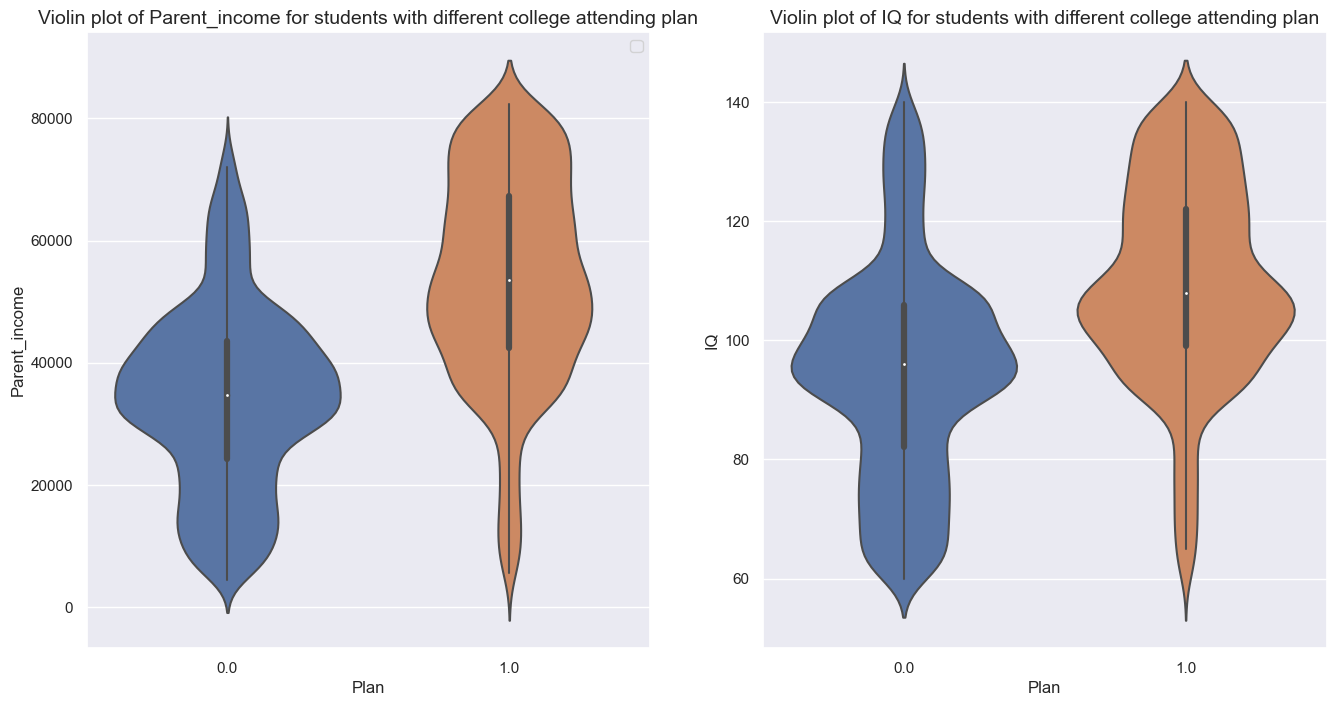

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
# Creation of figure with 2 axis
sns.set(style="ticks")
sns.set_style("darkgrid")
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
# Creation of 1st axis
sns.violinplot(x="Plan", y="Parent_income", data=college, ax=ax[0])
ax[0].legend(loc='upper right')
ax[0].set_title("Violin plot of Parent_income for students with different college attending plan", fontsize=14)
# Creation of 2nd axis
sns.violinplot(x="Plan", y="IQ", data=college, ax=ax[1])
ax[1].set_title("Violin plot of IQ for students with different college attending plan", fontsize=14)
# Close the empty Figure 2 created by seaborn.
plt.close(2)

## Frequency plot of Gender、Encourage & Plan

<Figure size 1500x600 with 0 Axes>

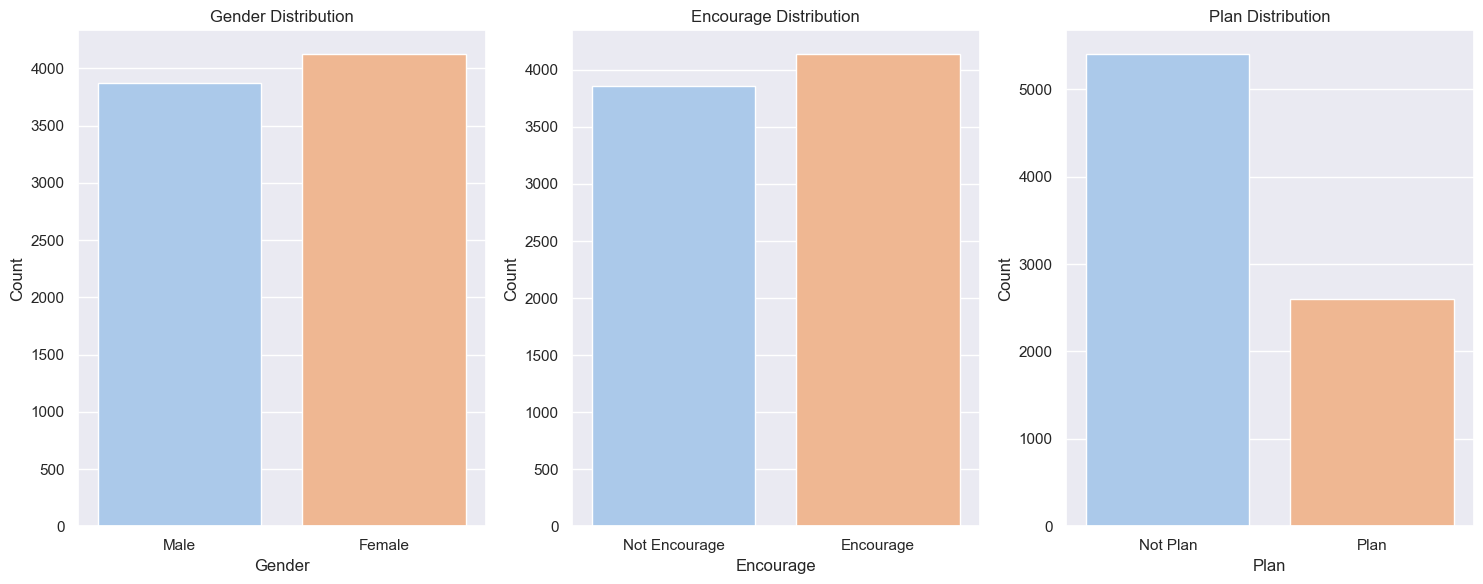

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# 设置绘图的大小
plt.figure(figsize=(15, 6))

# 创建 1x3 的子图布局
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

# 绘制 Gender 的 countplot
sns.countplot(x='Gender', data=college, palette='pastel', ax=axes[0])
axes[0].set_title('Gender Distribution')
axes[0].set_xlabel('Gender')
axes[0].set_ylabel('Count')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Male', 'Female'])

# 绘制 Encourage 的 countplot
sns.countplot(x='Encourage', data=college, palette='pastel', ax=axes[1])
axes[1].set_title('Encourage Distribution')
axes[1].set_xlabel('Encourage')
axes[1].set_ylabel('Count')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Not Encourage', 'Encourage'])

# 绘制 Plan 的 countplot
sns.countplot(x='Plan', data=college, palette='pastel', ax=axes[2])
axes[2].set_title('Plan Distribution')
axes[2].set_xlabel('Plan')
axes[2].set_ylabel('Count')
axes[2].set_xticks([0, 1])
axes[2].set_xticklabels(['Not Plan', 'Plan'])

# 调整布局
plt.tight_layout()

# 显示图形
plt.show()

From these visualizations, we can conclude:

1. **Gender**: There is an almost equal distribution between male and female students.
2. **Parent Income**: Most students have parents with incomes ranging from lower to middle levels.
3. **IQ**: IQ scores follow a normal distribution.
4. **Encourage**: There are more students who are not encouraged to plan for college.
5. **Plan**: Fewer students plan to attend college compared to those who do not.
6. **Class Imbalance**: One of the classes in the `Plan` data has less than 40% or more than 60% of the data, indicating an imbalance in the dataset.

## Paired variables:

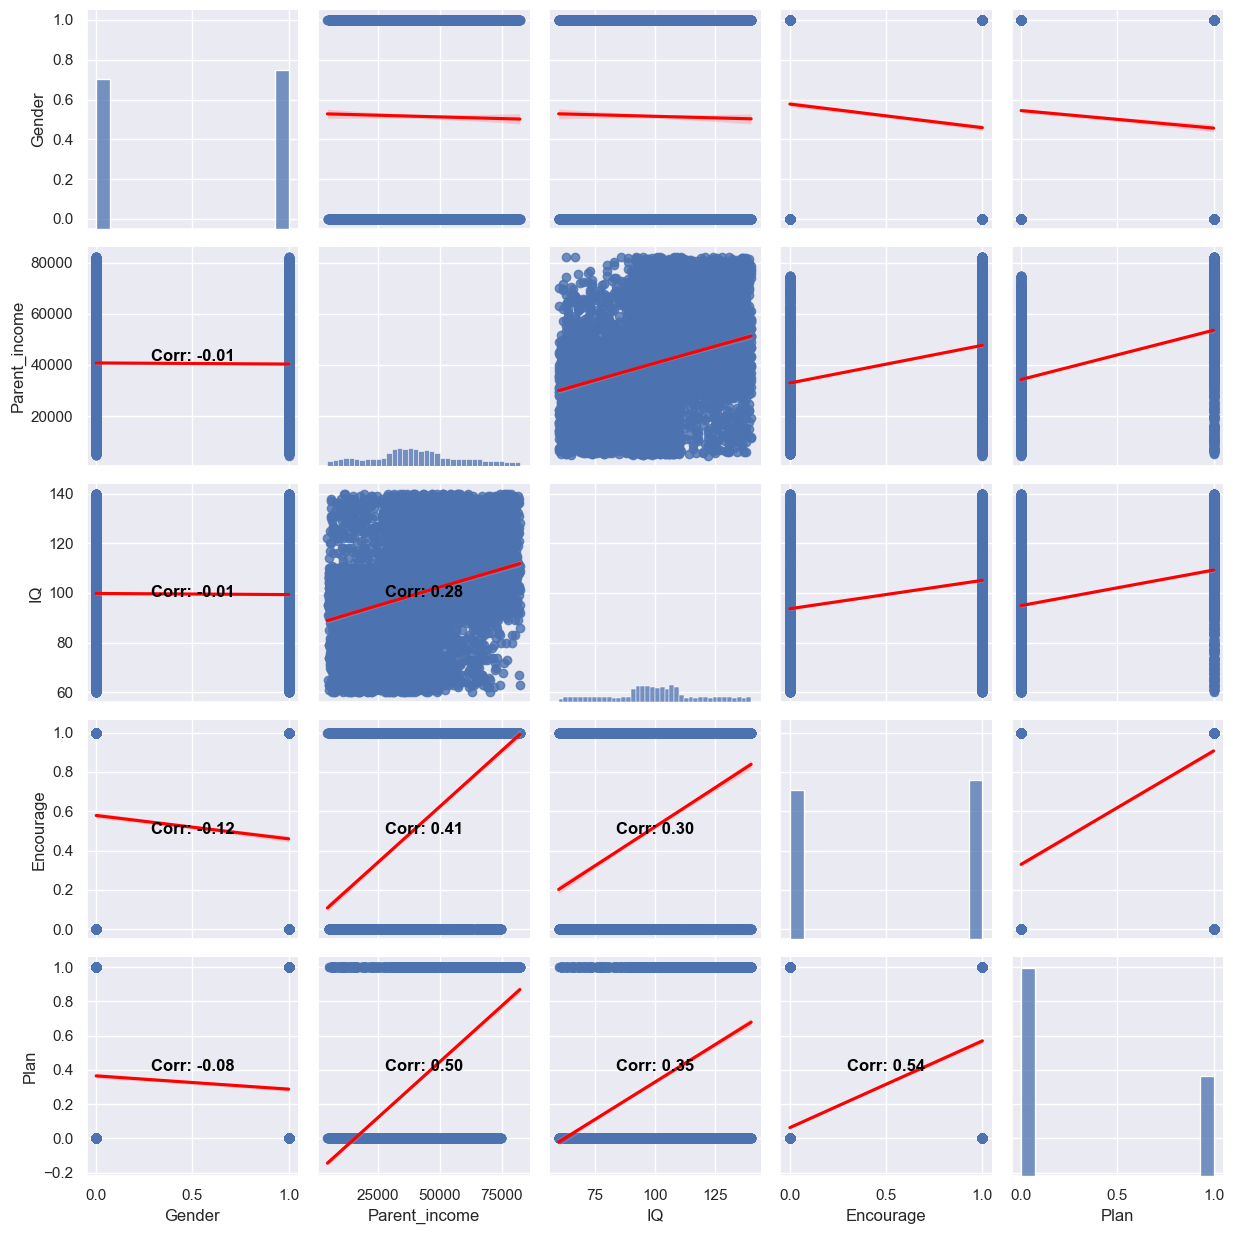

In [23]:

# 选择需要分析的数值列（去除 StudentID）
cols = college.drop(columns=['StudentID'])

# 计算相关系数矩阵
corr_matrix = cols.corr()

# 绘制散点图矩阵，添加回归线
g = sns.pairplot(cols, kind='reg', plot_kws={'line_kws': {'color': 'red'}})

# 在每个子图上添加相关系数
for i in range(len(cols.columns)):
    for j in range(i):
        # 获取对应位置的相关系数
        corr_value = corr_matrix.iloc[i, j]
        
        # 在子图上添加文本
        g.axes[i, j].text(0.5, 0.5, f'Corr: {corr_value:.2f}', 
                          horizontalalignment='center',
                          verticalalignment='center',
                          fontsize=12, color='black', weight='bold', 
                          transform=g.axes[i, j].transAxes)

# 显示图形
plt.tight_layout()
plt.show()

From these visualizations, we can conclude:

1. **Gender and Plan**: There is no significant difference in college planning between male and female students.
2. **Parent Income and Plan**: Students who plan to attend college tend to have parents with higher incomes.
3. **IQ and Plan**: Students with higher IQ scores are more likely to plan to attend college.
4. **Encourage and Plan**: Encouragement has a significant impact on college planning, with students who are encouraged being more likely to plan to attend college.

## Hypothesis Testing

Some hypotheses to be tested:

1. **Parent Income and Plan**
   * H0: There is no significant difference in parent income between students who plan to attend college and those who do not.
   * H1: There is a significant difference in parent income between students who plan to attend college and those who do not.

2. **Gender and Plan**
   * H0: There is no significant difference between male and female students.
   * H1: There is a significant difference between male and female students.

3. **IQ and Plan**
   * H0: There is no significant difference in IQ scores between students who plan to attend college and those who do not.
   * H1: There is a significant difference in IQ scores between students who plan to attend college and those who do not.

4. **Encourage and Plan**
   * H0: There is no significant difference between students who are encouraged to attend college and those who are not.
   * H1: There is a significant difference between students who are encouraged to attend college and those who are not.

To test these hypotheses, a t-test is conducted for continuous variables (Parent Income and IQ) and a chi-square test for categorical variables.

In [24]:
# Hypothesis Testing: Parent Income and Plan
from scipy.stats import ttest_ind, chi2_contingency

plan_income = college[college['Plan'] == 1]['Parent_income']
not_plan_income = college[college['Plan'] == 0]['Parent_income']
t_stat_income, p_val_income = ttest_ind(plan_income, not_plan_income)

print(f"t-statistic: {t_stat_income}, p-value: {p_val_income}")

t-statistic: 51.82897277041303, p-value: 0.0


There are significant differences in parental income between students who do and do not plan to attend college. Higher parental income was associated with planning for college.

In [25]:
# Hypothesis Testing: Gender and Plan
gender_plan_table = pd.crosstab(college['Gender'], college['Plan'])
chi2_gender, p_val_gender, _, _ = chi2_contingency(gender_plan_table)

print(f"chi-square statistic: {chi2_gender}, p-value: {p_val_gender}")

chi-square statistic: 54.546068590667275, p-value: 1.518461176916288e-13


There are significant differences in college planning between male and female students, although the effect size needs to be further investigated.

In [26]:
# Hypothesis Testing: IQ and Plan
plan_iq = college[college['Plan'] == 1]['IQ']
not_plan_iq = college[college['Plan'] == 0]['IQ']
t_stat_iq, p_val_iq = ttest_ind(plan_iq, not_plan_iq)

print(f"t-statistic: {t_stat_iq}, p-value: {p_val_iq}")

t-statistic: 33.80929822488436, p-value: 2.4960449353161297e-234


There is a significant difference in IQ scores between students who do and do not plan to attend college. Higher IQ scores are associated with planning for college.

In [27]:
# Hypothesis Testing: Encourage and Plan
encourage_plan_table = pd.crosstab(college['Encourage'], college['Plan'])
chi2_encourage, p_val_encourage, _, _ = chi2_contingency(encourage_plan_table)

print(f"chi-square statistic: {chi2_encourage}, p-value: {p_val_encourage}")

chi-square statistic: 2337.8862249734784, p-value: 0.0


There were significant differences in college planning between encouraged and non-encouraged students. Encouragement significantly increases the likelihood of planning for college.

## Data preprocessing
The type of the data in the dataset is double, eliminating the need for additional preprocessing. The only required step is to **split the data into training and testing sets**.

### Split the training and testing set

In [28]:
college_scl

,StudentID,Gender,Parent_income,IQ,Encourage,Plan
0,4558,0.0,0.738529,0.973519,1.0,1.0
1,4561,1.0,-0.869877,-0.664979,0.0,0.0
2,4563,1.0,1.398530,-0.347850,0.0,0.0
3,4565,0.0,-1.616399,0.920664,1.0,1.0
4,4567,1.0,-1.324668,0.127842,0.0,0.0
...,...,...,...,...,...,...
7996,7996,1.0,0.424612,-0.136431,1.0,0.0
7997,7998,0.0,0.372478,-1.880639,0.0,0.0
7998,7999,0.0,-0.919793,0.180697,1.0,0.0
7999,8000,0.0,2.141724,0.022133,1.0,1.0


In [29]:
# Build an one-hot encoder
oneHotEncoder = OneHotEncoder()
# Train the one-hot encoder to get the transformation of columns that need to be processed by one-hot encoder
oneHotEncoder.fit(college_scl[['Gender', 'Encourage']])
# Transform the data
oneHotData = oneHotEncoder.transform(college_scl[['Gender', 'Encourage']])

# Combine the data obtained from the one-hot code with the parental income and IQ
x = hstack([
    oneHotData, 
    college_scl.Parent_income.values.reshape(-1, 1), 
    college_scl.IQ.values.reshape(-1, 1)
])
# pd.DataFrame(x.toarray()[:5])
# The response variable
y = college_scl["Plan"]

In [30]:
# Split the dataset into training set (70%) and testing set (30%), the random_state is used to control randomness
from sklearn.model_selection import train_test_split # Import the training and testing dataset splitter
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

# Model building 

**Random Forest** is a popular machine learning algorithm used for both classification and regression tasks. It is an **ensemble learning method** that combines multiple decision trees to make a final prediction.

***Relationship with Decision Trees***

Before we dive into Random Forest, it is important to understand the relationship between **Random Forest** and **Decision Trees**. A Decision Tree splits the dataset into smaller subsets by creating a tree-like structure of decisions and their possible consequences. Each decision tree node represents a question or test about one of the features, and each branch represents the outcome of that test. The final decision is made by following the path from the root to a leaf node.

**Random Forest** works by **combining multiple Decision Trees** to make a final prediction. Each Decision Tree in the Random Forest is **trained on a random subset** of the training data and randomly selected **features**. By doing so, Random Forest can overcome the problem of overfitting that can occur when training a single Decision Tree on the entire dataset.

***Working of Random Forest***

Let's take a look at how Random Forest works step by step. Assume we have a dataset of n samples with m features, and we want to predict a binary outcome variable y. Here are the steps:

1. **Feature sampling:** **Randomly select k features without replacement** from the total m features where k << m. In Random Forest, the value of k is often the square root of m.
2. **Bootstrap aggregating (Bagging):** For each of the k features, create a Decision Tree using a **random subset of n samples**. Sampling is done **with replacement**, which means that a sample can be chosen more than once, leading to the creation of different Decision Trees.
3. **Decision tree growing:** For each feature, **grow a Decision Tree** by recursively splitting the dataset into two subsets based on the optimal split criterion. The optimal split criterion is determined by maximizing the information gain or minimizing the impurity of the split. The Decision Tree **stops growing when the maximum depth is reached or no further improvement in the impurity measure can be achieved**.
4. Repeat steps 1-3 to create a forest of k Decision Trees.

To make a **prediction** on a new sample, pass it through all k Decision Trees, and count the number of times it is classified as a positive outcome. The final prediction is made by taking the **majority vote** of the k Decision Trees. For example, if the sample is classified as positive in 4 out of 5 Decision Trees, the final prediction will be positive.

***Example***

In the illustration below, the dataset comprises of 5 features and 5 observations. Each decision tree in the Random Forest is built using a subset that **randomly** selects 3 features **without replacement** and 5 observations **with replacement**. In subset 1, the features X1, X3, and X4 are selected, and observations 1, 2, and 5 are chosen, with observations 1 and 2 being **selected twice**. The decision trees are grown without pruning, and the final decision is aggregated by **majority voting**.

<img src='https://media.springernature.com/full/springer-static/image/chp%3A10.1007%2F978-3-030-89010-0_15/MediaObjects/484261_1_En_15_Fig4_HTML.png?as=webp' width=800>

In the analyses below, we use the `GridSearchCV` to find the optimal parameters. The range of the hyperparameters are illustrted.

In [31]:
# Executed duration: 60 second
# Import the RandomForestClassifier module
from sklearn.ensemble import RandomForestClassifier

# Initialize a basic random forest model
rfClassifier = RandomForestClassifier(random_state=1)

# Define a dictionary of hyperparameters to tune
paramGrid = dict(
    max_depth= [5, 6, 7, 8, 9, 10],
    criterion=['gini', 'entropy'],    
    max_leaf_nodes=[10, 11, 12, 13, 14, 15],
    n_estimators=np.arange(10,60,10)
)

# Perform hyperparameter tuning using GridSearchCV with cross-validation
gridSearchCV = GridSearchCV(
    rfClassifier, paramGrid, 
    cv=10, verbose=1, n_jobs=-1,
    return_train_score=True
)

# Fit the model with the data and hyperparameters to find the best combination of hyperparameters
grid = gridSearchCV.fit(x_train, y_train)

# Print the best score and parameters found
print('The optimal score is : %f' % grid.best_score_)
print('The optimal parameters are:')
for key in grid.best_params_.keys():
    print('%s=%s'%(key, grid.best_params_[key]))

Fitting 10 folds for each of 360 candidates, totalling 3600 fits
The optimal score is : 0.837143
The optimal parameters are:
criterion=entropy
max_depth=5
max_leaf_nodes=15
n_estimators=50


Using `GridSearchCV`, we find the best model in our search range. The optimal **Accuarcy is 0.8373** and the optimal parameters are (The optimal outcome of cross-validation can potentially differ across multiple runs due to the inherent randomness in the process.):
 - criterion=gini
 - max_depth=6
 - max_leaf_nodes=13
 - n_estimators=50
 
Then, we can train the Random Forest model with optimal parameters:

In [32]:
#Bulid the Random Forest with the optimal parameters
random_forest_opt = RandomForestClassifier(
criterion='gini',
max_depth=6,
max_leaf_nodes=13,
n_estimators=50,
)
random_forest_opt.fit (x,y)

# Bulid the Decision Tree with the optimal parameters 
decision_tree_opt = DecisionTreeClassifier(
    max_depth=4,
    max_leaf_nodes=7) 
decision_tree_opt.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=4, max_leaf_nodes=7)

# Model comparison

In this section, we will built the optimal Decision tree model we acquired in the ***Case study 1: College Attending Plan Modeled by Decision Tree*** and compare the optimal Decision Tree model with the Random Forest model in the **testing set**.

In [35]:
# Building models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(
    criterion='gini',
    max_depth=6, 
    max_leaf_nodes=13,
    n_estimators=50
),
    "SVM": SVC(probability=True),
    "Gradient Boosting": GradientBoostingClassifier()
}

### Evaluating models
def evaluate_model(model, X_train_smote, X_test, y_train_smote, y_test):
    model.fit(X_train_smote, y_train_smote)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else y_pred

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    conf_matrix = confusion_matrix(y_test, y_pred)

    return accuracy, precision, recall, f1, roc_auc, conf_matrix

results = {}
for name, model in models.items():
    accuracy, precision, recall, f1, roc_auc, conf_matrix = evaluate_model(model, x_train, x_test, y_train, y_test)
    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'Confusion Matrix': conf_matrix
    }

In [36]:
metrics_df = pd.DataFrame(results).T[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']]
metrics_df.head()

,Accuracy,Precision,Recall,F1-Score,ROC-AUC
Logistic Regression,0.8025,0.64335,0.853595,0.733708,0.897119
Decision Tree,0.780417,0.646914,0.684967,0.665397,0.754733
Random Forest,0.8475,0.779804,0.726797,0.752368,0.902524
SVM,0.839167,0.775837,0.696732,0.73416,0.859064
Gradient Boosting,0.845417,0.784682,0.709804,0.745367,0.902514


In [47]:
# 提取 Random Forest 的各个指标
rf_metrics = metrics_df.loc['Random Forest']

# 计算相对于 Random Forest 的提升
relative_improvement = (rf_metrics - metrics_df) / rf_metrics * 100

# 显示相对提升的结果
relative_improvement

,Accuracy,Precision,Recall,F1-Score,ROC-AUC
Logistic Regression,5.309735,17.498494,-17.446043,2.480196,0.598926
Decision Tree,7.915438,17.041478,5.755396,11.559667,16.375317
Random Forest,0.0,0.0,0.0,0.0,0.0
SVM,0.983284,0.508676,4.136691,2.42013,4.815368
Gradient Boosting,0.245821,-0.625598,2.338129,0.930512,0.001107


The Accuracy for the Random Forest and the Decision Tree on the testing set are **0.8495** and **0.8413** respectively. **The Accuracy of the Random Forest is a little higher**.

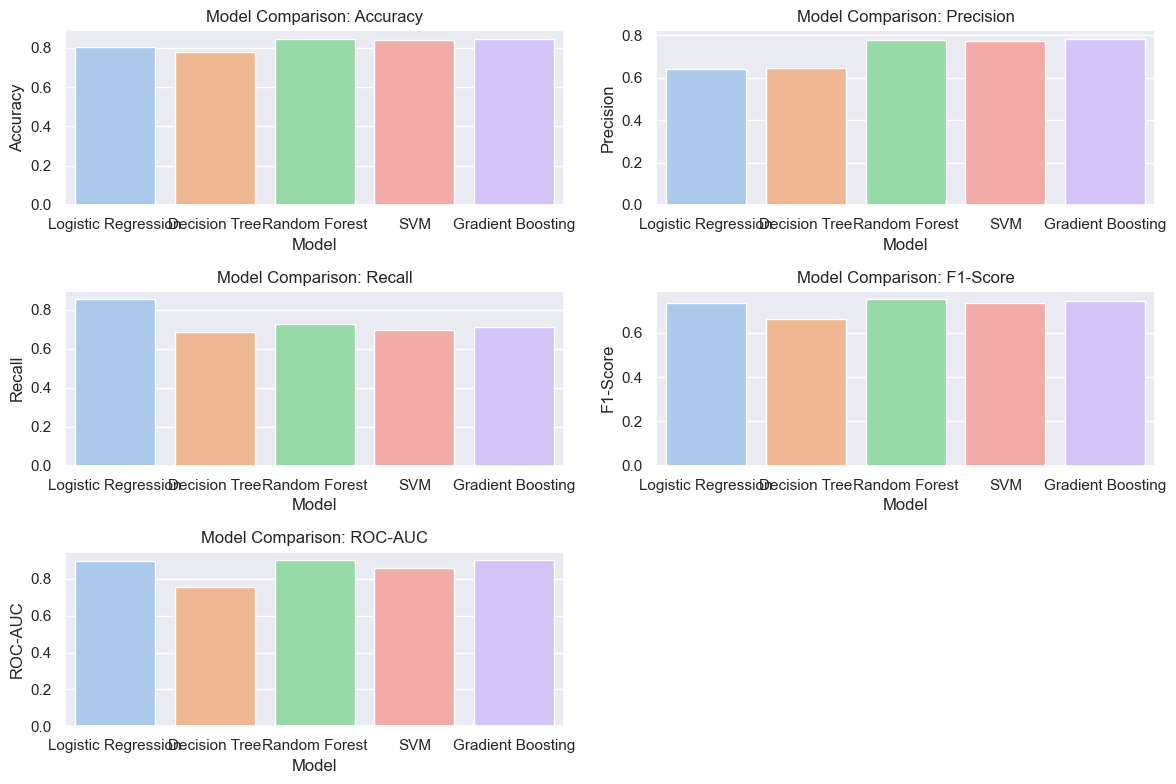

In [37]:
plt.figure(figsize=(12, 8))

for i, metric in enumerate(metrics_df.columns):
    plt.subplot(3, 2, i+1)
    sns.barplot(x=metrics_df.index, y=metrics_df[metric], palette='pastel')
    plt.title(f'Model Comparison: {metric}')
    plt.xlabel('Model')
    plt.ylabel(metric)

plt.tight_layout()
plt.show()

## Confusion matrices
We then compare models in terms of the **confusion matrices** obtained on the testing data set. *For detailed introduction of Confusion matrices, see Case study 3.*

In [38]:
# Define a function to calculate the confusion matrix
from sklearn.metrics import confusion_matrix # import confusion matrix module
def calculate_confusion_matrix(y_true, y_pred, labels):
    confu_mat = pd.DataFrame(confusion_matrix(y_true, y_pred, normalize=None, labels=labels))
    return round(confu_mat, 2)  # formatting the output

In [39]:
# Confusion matrix of Random Forest
calculate_confusion_matrix(y_test, random_forest_opt.predict(x_test), labels=[0,1])

,0,1
0,1479,156
1,212,553


In [40]:
# Confusion matrix of Decision Tree
calculate_confusion_matrix(y_test, decision_tree_opt.predict(x_test), labels=[0,1])

,0,1
0,1498,137
1,242,523


In the presented confusion matrix, the label 0 and 1 correspond to the 'not plan' and 'plan' classes, respectively.  Relative to the Decision Tree method, the Random Forest approach demonstrates superiority by averting $246-204=42$ additional positive samples from being erroneously classified as negative, albeit at the expense of incorrectly assigning $155-135=20$ more negative samples to the positive class.  Given that the correct identification of both positive and negative samples is equally essential to our analysis, **the Random Forest model is deemed to be superior to the Decision Tree method**.

## ROC curve and AUC

Last but not least, we assess the performance of the Decision Tree model and the Random Forest model. *For detail introduction of ROC curve and AUC, see Case study 3*

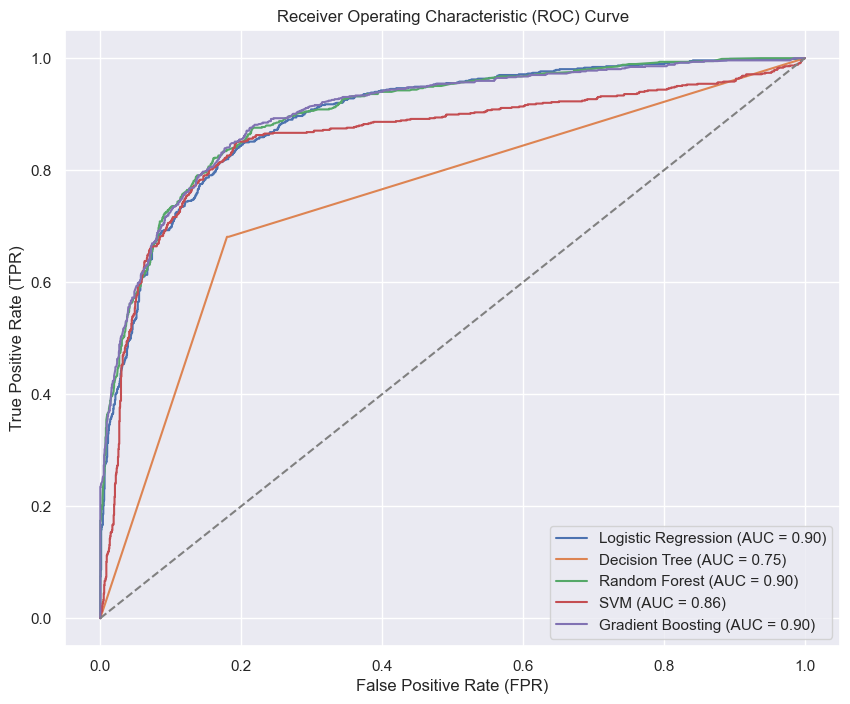

In [44]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 绘制所有模型的 ROC 曲线
plt.figure(figsize=(10, 8))

# 计算并绘制每个模型的 ROC 曲线
for name, model in models.items():
    # 训练模型
    model.fit(x_train, y_train)
    
    # 计算预测概率
    y_pred_prob = model.predict_proba(x_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
    
    # 计算 ROC 曲线数据
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    
    # 计算 AUC
    roc_auc = auc(fpr, tpr)
    
    # 绘制 ROC 曲线
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# 绘制随机猜测线（对角线）
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# 设置图表属性
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.grid(True)

# 显示图形
plt.show()

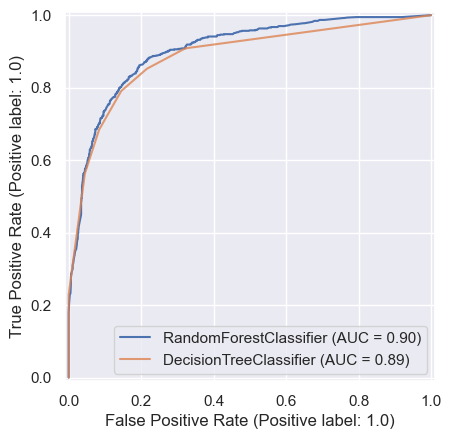

In [45]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import RocCurveDisplay

# plot the ROC curve of the Random Forest
roc_random_forest = RocCurveDisplay.from_estimator(random_forest_opt, x_test, y_test)
ax = plt.gca()
# plot the ROC curve of the Decision Tree
roc_decision_tree = RocCurveDisplay.from_estimator(decision_tree_opt, x_test, y_test, ax=ax, alpha=0.8)
plt.show()

Upon analyzing the ROC plot generated, it is evident that the Random Forest model consistently outperforms the Decision Tree model. Specifically, the ROC curve of the Random Forest is almost constantly higher than that of the Decision Tree. And the area under the ROC curve (AUC) of the Random Forest model, calculated to be 0.91, is significantly greater than that of the Decision Tree model. This observation implies that the **Random Forest model** has **superior classification performance** compared to the Decision Tree model.

# Summary report

## Objectives
The case study deals with the college attending plan which was previously discussed in **Case Study 1**, where we applied the **Decision Tree** model. In this study, we will utilize the **Random Forest** model, an ensembled version of the Decision Tree model, to make predictions.


## Organisation of the data
The data set contains a total of 8000 samples. Students use StudentID as a unique identifier. The explanatory variables include the gender of the student, the IQ of the student, the income of the parents, and whether the parents encouraged their children to attend college.

## Exploratory data analysis：
In the course of the exploratory data analysis, we find that `Encourage` has a strong discriminating effect on whether high school students attend college or not. In addition, we also find through the boxplot that `Parent_income` also have a good discrimination effect. After that, we used one-hot encoder to preprocess the data, so that the dataset could be processed by the decision tree model.

##  Model specification
The analysis objective suggested a predictive classification model that allocates high school students to categories with and without plan to go to college. Therefore, we consider **Random Forest**.

## Model comparison
Given that the Random Forest model is an **ensemble** method of the Decision Tree, we aim to build an optimal Decision Tree model based on the findings of Case Study 1: College Attending Plan Modeled by Decision Tree, and compare its performance with that of the Random Forest model on the testing set. By evaluating the **Accuracy** metric, we observe a slightly higher accuracy for the Random Forest model. Furthermore, upon examining the **Confusion Matrices**, we find that the Random Forest model outperforms the Decision Tree method in reducing the type 2 error rate, albeit at the cost of a slight increase in the type 1 error rate. We also observe that the **ROC curve** of the Random Forest model consistently outperforms that of the Decision Tree model, with a correspondingly higher **AUC score**. Overall, we conclude that the **Random Forest model exhibits superior classification performance compared to the Decision Tree model**, which further underscores the utility of ensemble methods in machine learning.